In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.ensemble import IsolationForest
from sklearn.base import BaseEstimator, RegressorMixin

df = pd.read_excel("dataset.xlsx")
df.drop(columns=["Seli", "Tarih"], inplace=True, errors='ignore')

def extract_mcc(value):
    if pd.isnull(value):
        return np.nan
    match = re.match(r"(\d{4})-", value)
    if match:
        return match.group(1)
    else:
        return np.nan

df['mccinfo'] = df['mccinfo'].apply(extract_mcc)
num_missing_mcc = df['mccinfo'].isnull().sum()
print(f"mccinfo değeri bulunamadığı için silinecek satır sayısı: {num_missing_mcc}")
df = df.dropna(subset=['mccinfo'])

numeric_columns = [
    "bıst100_Kapanış", "bıst100_Açılış", "bıst100_Yüksek", "bıst100_Düşük",
    "Euro_Kapanış", "Euro_Açılış", "Euro_Yüksek", "Euro_Düşük",
    "USD_Kapanış", "USD_Açılış", "USD_Yüksek", "USD_Düşük",
]

def fix_numeric_value(s):
    s = s.replace(',', '.')
    if s.count('.') > 1:
        second_dot = s.find('.', s.find('.') + 1)
        s = s[:second_dot]
    return s

for col in numeric_columns:
    df[col] = df[col].astype(str).apply(fix_numeric_value)
    df[col] = df[col].astype(float)

categorical_columns = ["Şehir", "İlçe", "mccinfo"]
le = LabelEncoder()
for col in categorical_columns:
    df[col] = le.fit_transform(df[col])

# Hedef ve özelliklerin ayrılması
target = "Tek Çekim Komisyon Oranı (Güncel)"
X = df.drop(columns=[target])
y = df[target]

mccinfo değeri bulunamadığı için silinecek satır sayısı: 15


In [2]:
# Isolation Forest 
data_for_outlier = X.copy()
data_for_outlier[target] = y

# IsolationForest modeli
iso_forest = IsolationForest(n_estimators=100, contamination="auto", random_state=42)
outlier_pred = iso_forest.fit_predict(data_for_outlier)

# Aykırı değerlerin tespiti (-1)
mask = outlier_pred == 1
print(f"Toplam örnek sayısı: {len(data_for_outlier)}")
print(f"Aykırı tespit edilen örnek sayısı: {np.sum(outlier_pred == -1)}")

# Temizlenmiş veri seti 
X_clean = X[mask]
y_clean = y[mask]

Toplam örnek sayısı: 1692
Aykırı tespit edilen örnek sayısı: 286


In [ ]:
# ELM Regressor Modeli
class ELMRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_hidden=50, activation='sigmoid', random_state=None):
        self.n_hidden = n_hidden
        self.activation = activation
        self.random_state = random_state

    def _activation(self, x):
        if self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        elif self.activation == 'relu':
            return np.maximum(0, x)
        elif self.activation == 'tanh':
            return np.tanh(x)
        else:
            raise ValueError("Bilinmeyen aktivasyon fonksiyonu.")

    def fit(self, X, y):
        n_samples, n_features = X.shape
        rng = np.random.RandomState(self.random_state)

        # Rastgele input ağırlıkları ve bias değerleri oluştur
        self.input_weights_ = rng.randn(n_features, self.n_hidden)
        self.bias_ = rng.randn(self.n_hidden)

        # Gizli katmanın çıktısı hesap
        H = self._activation(np.dot(X, self.input_weights_) + self.bias_)

        # Çıkış ağırlıkları
        self.beta_ = np.linalg.pinv(H).dot(y)
        return self

    def predict(self, X):
        H = self._activation(np.dot(X, self.input_weights_) + self.bias_)
        return np.dot(H, self.beta_)


# 10 katlı çapraz doğrulama
elm_model = ELMRegressor(n_hidden=50, activation='sigmoid', random_state=42)

kfold = KFold(n_splits=10, shuffle=True, random_state=42)
y_pred = cross_val_predict(elm_model, X_clean, y_clean, cv=kfold)


# Model Performansı
mae = mean_absolute_error(y_clean, y_pred)
mape = mean_absolute_percentage_error(y_clean, y_pred)
r2 = r2_score(y_clean, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"R2 Score: {r2}")



Mean Absolute Error (MAE): 0.5129184154085059
Mean Absolute Percentage Error (MAPE): 0.12110954475159129
R2 Score: 0.025776986085552456


C:\Users\yagiz\AppData\Local\Temp\ipykernel_10484\2632692088.py:10: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


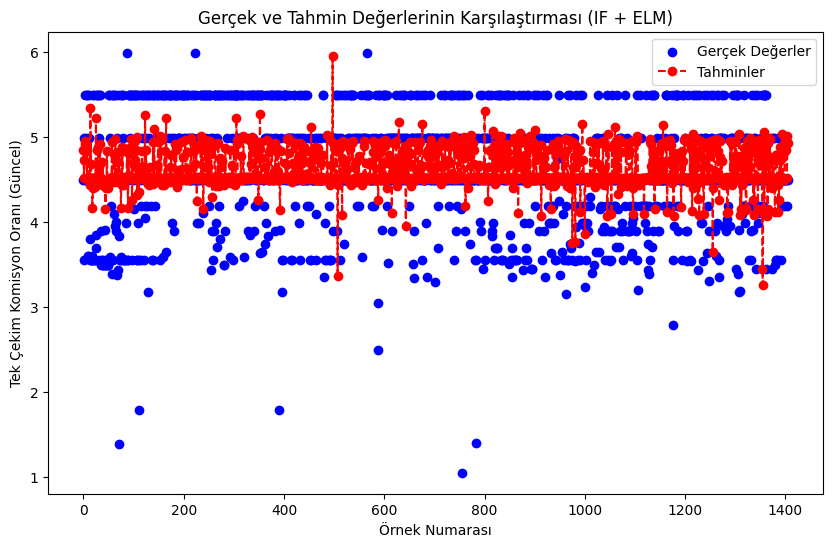

In [ ]:

plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_clean)), y_clean, color='blue', label='Gerçek Değerler')
plt.plot(range(len(y_pred)), y_pred, color="red", label="Tahminler", linestyle="--", marker="o")
plt.title("Gerçek ve Tahmin Değerlerinin Karşılaştırması (IF + ELM)")
plt.xlabel("Örnek Numarası")
plt.ylabel("Tek Çekim Komisyon Oranı (Güncel)")
plt.legend()
plt.show()
